In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [3]:
df_store = pd.read_csv('store.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning and feature building

In [4]:
# Transformation on train data 
df_train.fillna(0, inplace=True)
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['Month'] = df_train.Date.apply(lambda dt: dt.month)
df_train['Year'] = df_train.Date.apply(lambda dt: dt.year)
df_train['Day'] = df_train.Date.apply(lambda dt: dt.day)
df_train['wom'] = df_train.Date.apply(lambda dt: (dt.day-1)//7 + 1)
df_train_custsales = df_train[['Store','Customers','Sales']]
df_train['Open'] = df_train['Open'].map(lambda x : float(x))
df_train['SchoolHoliday'] = df_train['SchoolHoliday'].astype(int) 
df_train = df_train.merge(df_store,  on = 'Store')

df_test.fillna(0, inplace=True)
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Month'] = df_test.Date.apply(lambda dt: dt.month)
df_test['Year'] = df_test.Date.apply(lambda dt: dt.year)
df_test['Day'] = df_test.Date.apply(lambda dt: dt.day)
df_test['wom'] = df_test.Date.apply(lambda dt: (dt.day-1)//7 + 1)
df_test['SchoolHoliday'] = df_test['SchoolHoliday'].astype(int) 
df_test = df_test.merge(df_store,  on = 'Store')

In [5]:
df_train['prev_wom'] = df_train.groupby(['Month','DayOfWeek','wom','Store'])['Sales'].shift(1)
df_train['prev_wom'].fillna(df_train['Sales'],inplace=True)

In [6]:
from datetime import datetime
for_test = df_train[(df_train["Date"]>=datetime(2014,7,1)) & (df_train["Date"]<=datetime(2014,9,30))]

In [7]:
for_test = for_test[['Month','DayOfWeek','wom','Store','Sales']]
for_test.columns = ['Month','DayOfWeek','wom','Store','prev_wom']

In [8]:
df_test = pd.merge(df_test,for_test,how='left',on=['Month','DayOfWeek','wom','Store'])

In [9]:
for_test_na = df_train.groupby('Store')['prev_wom'].median().reset_index()
for_test_na.columns = ['Store','prev_wom_change']
df_test = pd.merge(df_test,for_test_na,how='left',on=['Store'])

In [10]:
df_test.loc[df_test['prev_wom'].isnull(),'prev_wom']=df_test['prev_wom_change']

In [11]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prev_wom,prev_wom_change
0,1,1,4,2015-09-17,1.0,1,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3740.0,4209.0
1,857,1,3,2015-09-16,1.0,1,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4383.0,4209.0
2,1713,1,2,2015-09-15,1.0,1,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4381.0,4209.0
3,2569,1,1,2015-09-14,1.0,1,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3676.0,4209.0
4,3425,1,7,2015-09-13,0.0,0,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0.0,4209.0


In [12]:
df_train.loc[df_train['StoreType'] == 'a', 'StoreType'] = '1'
df_train.loc[df_train['StoreType'] == 'b', 'StoreType'] = '2'
df_train.loc[df_train['StoreType'] == 'c', 'StoreType'] = '3'
df_train.loc[df_train['StoreType'] == 'd', 'StoreType'] = '4'

df_test.loc[df_test['StoreType'] == 'a', 'StoreType'] = '1'
df_test.loc[df_test['StoreType'] == 'b', 'StoreType'] = '2'
df_test.loc[df_test['StoreType'] == 'c', 'StoreType'] = '3'
df_test.loc[df_test['StoreType'] == 'd', 'StoreType'] = '4'

In [13]:
df_train.loc[df_train['Assortment'] == 'a', 'Assortment'] = '1'
df_train.loc[df_train['Assortment'] == 'b', 'Assortment'] = '2'
df_train.loc[df_train['Assortment'] == 'c', 'Assortment'] = '3'

df_test.loc[df_test['Assortment'] == 'a', 'Assortment'] = '1'
df_test.loc[df_test['Assortment'] == 'b', 'Assortment'] = '2'
df_test.loc[df_test['Assortment'] == 'c', 'Assortment'] = '3'

In [14]:
df_train['StateHoliday'] = df_train['StateHoliday'].replace(0, '0')
df_train.loc[df_train['StateHoliday'] == 'a', 'StateHoliday'] = '1'
df_train.loc[df_train['StateHoliday'] == 'b', 'StateHoliday'] = '2'
df_train.loc[df_train['StateHoliday'] == 'c', 'StateHoliday'] = '3'

df_test['StateHoliday'] = df_test['StateHoliday'].replace(0, '0')
df_test.loc[df_test['StateHoliday'] == 'a', 'StateHoliday'] = '1'
df_test.loc[df_test['StateHoliday'] == 'b', 'StateHoliday'] = '2'
df_test.loc[df_test['StateHoliday'] == 'c', 'StateHoliday'] = '3'

In [15]:
df_train.loc[df_train['PromoInterval'].isnull(), 'PromoInterval'] = '1'
df_train.loc[df_train['PromoInterval'] == 'Jan,Apr,Jul,Oct', 'PromoInterval'] = '2'
df_train.loc[df_train['PromoInterval'] == 'Feb,May,Aug,Nov', 'PromoInterval'] = '3'
df_train.loc[df_train['PromoInterval'] == 'Mar,Jun,Sept,Dec', 'PromoInterval'] = '4'


df_test.loc[df_test['PromoInterval'].isnull(), 'PromoInterval'] = '1'
df_test.loc[df_test['PromoInterval'] == 'Jan,Apr,Jul,Oct', 'PromoInterval'] = '2'
df_test.loc[df_test['PromoInterval'] == 'Feb,May,Aug,Nov', 'PromoInterval'] = '3'
df_test.loc[df_test['PromoInterval'] == 'Mar,Jun,Sept,Dec', 'PromoInterval'] = '4'

In [16]:
mean_data = df_train_custsales.groupby('Store').agg({'Sales':'mean','Customers':'mean'}).reset_index()

In [17]:
df_train = df_train.merge(mean_data,  on = 'Store')

df_test = df_test.merge(mean_data,  on = 'Store')

In [18]:
df_train['CompetitionDistance'].fillna(df_train['CompetitionDistance'].median(), inplace=True)
df_train['CompetitionDistance'] = np.log(df_train.CompetitionDistance) + 1

df_test['CompetitionDistance'].fillna(df_test['CompetitionDistance'].median(), inplace=True)
df_test['CompetitionDistance'] = np.log(df_test.CompetitionDistance) + 1

In [19]:
# Only the open days 
df_train = df_train[df_train["Open"] != 0]

In [20]:

df_train = df_train[df_train.columns.drop(['Day','Store','Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Year'])]

df_test = df_test[df_test.columns.drop(['Day','Store','Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Year'])]

In [21]:
# Convert factors
df_train = pd.get_dummies(df_train, columns=['DayOfWeek', 'StateHoliday','StoreType', 'Assortment','Month'], dummy_na=False)

df_test = pd.get_dummies(df_test, columns=['DayOfWeek', 'StateHoliday','StoreType', 'Assortment','Month'], dummy_na=False)

In [22]:
df_test['StateHoliday_2']=0
df_test['StateHoliday_3']=0

df_test['Month_1'] = 0
df_test['Month_2'] = 0
df_test['Month_3'] = 0
df_test['Month_4'] = 0
df_test['Month_5'] = 0
df_test['Month_6'] = 0
df_test['Month_7'] = 0
df_test['Month_10'] = 0
df_test['Month_11'] = 0
df_test['Month_12'] = 0

In [23]:
y = df_train['Sales_x']

id_order = df_test['Id']

df_train = df_train.drop(["Sales_x",  "Customers_x"],axis=1)

df_test = df_test.drop(["Id"],axis=1)

df_train = df_train.rename(index=str, columns={"Sales_y": "Sales", "Customers_y": "Customers"})

df_test = df_test[df_train.columns]

## Split in Test and Train and Normalization

In [24]:
# Test and Train
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.05, random_state=1)

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

## Advanced boosting

In [26]:
# Use log on target column y
dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))
dvalid = xgb.DMatrix(X_test, np.log(y_test + 1))
dtest = xgb.DMatrix(df_test)

In [27]:
# Taking parameters
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 7,
          "subsample": 0.75,
          "colsample_bytree": 0.7,
          "silent": 1
          }

num_trees = 400

watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

In [28]:
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

[0]	eval-rmse:5.78979	train-rmse:5.78949	eval-rmspe:0.996898	train-rmspe:0.996888
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:4.05549	train-rmse:4.05491	eval-rmspe:0.982099	train-rmspe:0.982078
[2]	eval-rmse:2.84173	train-rmse:2.84106	eval-rmspe:0.940126	train-rmspe:0.940068
[3]	eval-rmse:1.99361	train-rmse:1.99293	eval-rmspe:0.860671	train-rmspe:0.860528
[4]	eval-rmse:1.40021	train-rmse:1.39968	eval-rmspe:0.749086	train-rmspe:0.748777
[5]	eval-rmse:0.987206	train-rmse:0.986777	eval-rmspe:0.622122	train-rmspe:0.621297
[6]	eval-rmse:0.699649	train-rmse:0.699377	eval-rmspe:0.498799	train-rmspe:0.49706
[7]	eval-rmse:0.502295	train-rmse:0.502224	eval-rmspe:0.392577	train-rmspe:0.389488
[8]	eval-rmse:0.367645	train-rmse:0.367814	eval-rmspe:0.310347	train-rmspe:0.304934
[9]	eval-rmse:0.279322	train-rmse:0.279876	eval-rmspe:0.253435	train-rmspe:0.245251
[10]	eval-rmse:0.22204	t

[96]	eval-rmse:0.135305	train-rmse:0.13017	eval-rmspe:0.180399	train-rmspe:0.155427
[97]	eval-rmse:0.135233	train-rmse:0.130054	eval-rmspe:0.180266	train-rmspe:0.155462
[98]	eval-rmse:0.13522	train-rmse:0.13002	eval-rmspe:0.180254	train-rmspe:0.155452
[99]	eval-rmse:0.135241	train-rmse:0.129811	eval-rmspe:0.180132	train-rmspe:0.1554
[100]	eval-rmse:0.135231	train-rmse:0.129741	eval-rmspe:0.180138	train-rmspe:0.155292
[101]	eval-rmse:0.135119	train-rmse:0.129602	eval-rmspe:0.18011	train-rmspe:0.155086
[102]	eval-rmse:0.135125	train-rmse:0.129562	eval-rmspe:0.180134	train-rmspe:0.155034
[103]	eval-rmse:0.135163	train-rmse:0.129521	eval-rmspe:0.180141	train-rmspe:0.155012
[104]	eval-rmse:0.135141	train-rmse:0.129473	eval-rmspe:0.180149	train-rmspe:0.154832
[105]	eval-rmse:0.13517	train-rmse:0.129459	eval-rmspe:0.180295	train-rmspe:0.154814
[106]	eval-rmse:0.135145	train-rmse:0.129351	eval-rmspe:0.180292	train-rmspe:0.1548
[107]	eval-rmse:0.135141	train-rmse:0.129323	eval-rmspe:0.180446	tr

[192]	eval-rmse:0.133165	train-rmse:0.124061	eval-rmspe:0.177761	train-rmspe:0.133691
[193]	eval-rmse:0.133133	train-rmse:0.124052	eval-rmspe:0.177681	train-rmspe:0.133678
[194]	eval-rmse:0.133121	train-rmse:0.124045	eval-rmspe:0.177704	train-rmspe:0.13367
[195]	eval-rmse:0.13312	train-rmse:0.123998	eval-rmspe:0.177663	train-rmspe:0.133631
[196]	eval-rmse:0.133096	train-rmse:0.123976	eval-rmspe:0.177652	train-rmspe:0.133619
[197]	eval-rmse:0.133081	train-rmse:0.123928	eval-rmspe:0.177721	train-rmspe:0.133594
[198]	eval-rmse:0.133055	train-rmse:0.12388	eval-rmspe:0.177699	train-rmspe:0.133571
[199]	eval-rmse:0.133053	train-rmse:0.123855	eval-rmspe:0.177763	train-rmspe:0.133581
[200]	eval-rmse:0.133025	train-rmse:0.123821	eval-rmspe:0.177719	train-rmspe:0.133564
[201]	eval-rmse:0.132987	train-rmse:0.123756	eval-rmspe:0.177695	train-rmspe:0.133506
[202]	eval-rmse:0.132978	train-rmse:0.123706	eval-rmspe:0.17768	train-rmspe:0.133488
[203]	eval-rmse:0.132973	train-rmse:0.123649	eval-rmspe:0.

[288]	eval-rmse:0.133639	train-rmse:0.121241	eval-rmspe:0.178809	train-rmspe:0.131312
[289]	eval-rmse:0.133648	train-rmse:0.121226	eval-rmspe:0.178841	train-rmspe:0.131325
[290]	eval-rmse:0.133653	train-rmse:0.121206	eval-rmspe:0.17885	train-rmspe:0.131318
[291]	eval-rmse:0.13365	train-rmse:0.121201	eval-rmspe:0.178854	train-rmspe:0.131308
[292]	eval-rmse:0.133633	train-rmse:0.12118	eval-rmspe:0.178699	train-rmspe:0.131269
[293]	eval-rmse:0.133632	train-rmse:0.121159	eval-rmspe:0.178684	train-rmspe:0.131243
[294]	eval-rmse:0.133711	train-rmse:0.121137	eval-rmspe:0.178797	train-rmspe:0.131219
[295]	eval-rmse:0.133633	train-rmse:0.121096	eval-rmspe:0.178793	train-rmspe:0.131208
[296]	eval-rmse:0.133626	train-rmse:0.121088	eval-rmspe:0.178715	train-rmspe:0.131204
[297]	eval-rmse:0.133617	train-rmse:0.121044	eval-rmspe:0.178723	train-rmspe:0.131184
[298]	eval-rmse:0.133652	train-rmse:0.121028	eval-rmspe:0.178736	train-rmspe:0.13112
[299]	eval-rmse:0.133637	train-rmse:0.120943	eval-rmspe:0.

[384]	eval-rmse:0.13414	train-rmse:0.11859	eval-rmspe:0.1795	train-rmspe:0.129469
[385]	eval-rmse:0.134153	train-rmse:0.118593	eval-rmspe:0.179464	train-rmspe:0.129445
[386]	eval-rmse:0.134152	train-rmse:0.11859	eval-rmspe:0.179407	train-rmspe:0.129458
[387]	eval-rmse:0.134147	train-rmse:0.118573	eval-rmspe:0.179386	train-rmspe:0.129453
[388]	eval-rmse:0.134152	train-rmse:0.11857	eval-rmspe:0.179388	train-rmspe:0.129281
[389]	eval-rmse:0.134161	train-rmse:0.118564	eval-rmspe:0.179441	train-rmspe:0.129263
[390]	eval-rmse:0.134153	train-rmse:0.118546	eval-rmspe:0.179445	train-rmspe:0.129234
[391]	eval-rmse:0.134155	train-rmse:0.11854	eval-rmspe:0.179394	train-rmspe:0.129224
[392]	eval-rmse:0.134154	train-rmse:0.118529	eval-rmspe:0.179387	train-rmspe:0.129205
[393]	eval-rmse:0.134133	train-rmse:0.118524	eval-rmspe:0.179231	train-rmspe:0.129189
[394]	eval-rmse:0.134117	train-rmse:0.118493	eval-rmspe:0.1792	train-rmspe:0.129165
[395]	eval-rmse:0.134592	train-rmse:0.118442	eval-rmspe:0.17918

In [35]:
validation_response = gbm.predict(xgb.DMatrix(X_test))
invalid_sales = validation_response < 0
validation_response[invalid_sales] = 0

In [36]:
rmspe(np.exp(validation_response) - 1, y_test)

0.1791158690512741

In [37]:
final_response = gbm.predict(xgb.DMatrix(df_test))
invalid_sales = final_response < 0
final_response[invalid_sales] = 0

store_closed = df_test['Open']==0
final_response[store_closed] = 0

In [38]:
final_response = np.exp(final_response) - 1

In [39]:
final_response = pd.Series(final_response,index=id_order)

In [40]:
final_response.to_csv('entry_9.csv')

## Linear/Ridge/Lasso

In [176]:
lin_reg = linear_model.LinearRegression()
d_tree = lin_reg
d_tree.fit(X_train_std, y_train)
y_pred_lin = d_tree.predict(X_test_std)

In [177]:
r2_score(y_test,y_pred_lin)

0.8369934011936219

In [178]:
rmspe(y_pred_lin,y_test)

0.24079030091901818

In [190]:
ridge_reg = linear_model.Ridge()
lasso_reg = linear_model.Lasso()

In [191]:
ridge_reg.fit(X_train_std, y_train)
lasso_reg.fit(X_train_std, y_train)
y_pred_ridge = ridge_reg.predict(X_test_std)
y_pred_lasso = lasso_reg.predict(X_test_std)

In [192]:
r2_score(y_test,y_pred_ridge)

0.836987033839252

In [193]:
r2_score(y_test,y_pred_lasso)

0.8369680296131354

In [194]:
rmspe(y_pred_ridge,y_test)

0.240833458945162

In [195]:
rmspe(y_pred_lasso,y_test)

0.24060942401659796

## Decision Tree

In [179]:
d_tree = DecisionTreeRegressor()
d_tree.fit(X_train, y_train)
y_pred_tree = d_tree.predict(X_test)

In [180]:
r2_score(y_test,y_pred_tree)

0.8425843357095362

In [181]:
rmspe(y_pred_tree,y_test)

0.2286806725764097

## Knn

In [ ]:
knn_st = neighbors.KNeighborsRegressor(n_neighbors=5)
knn_st.fit(X_train_std, y_train)
y_pred_knnst = knn_st.predict(X_test_std)

In [ ]:
r2_score(y_test,y_pred_knnst)

In [ ]:
rmspe(y_pred_knnst,y_test)

## Random Forest

In [182]:
clf_rf = RandomForestRegressor(random_state=123) 
clf_rf.fit(X_train_std, y_train)
y_pred_rf = clf_rf.predict(X_test_std)

In [183]:
r2_score(y_test,y_pred_rf)

0.8979439369248127

In [184]:
rmspe(y_pred_rf,y_test)

0.20233909101300013

## Gradient Boosting

In [186]:
gb = GradientBoostingRegressor(random_state=123) 

In [187]:
gb.fit(X_train_std, y_train)
y_pred_gb = gb.predict(X_test_std)

In [188]:
r2_score(y_test,y_pred_gb)

0.8859208211335522

In [189]:
rmspe(y_pred_gb,y_test)

0.20921159073209736

## Sequental neural network

In [196]:
from keras.models import Sequential
from keras.layers import Dense
from livelossplot import PlotLossesKeras

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [197]:
y_train = np.array(y_train)

In [198]:
model = Sequential()
input_dim = X_train_std.shape[1]

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [199]:
model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

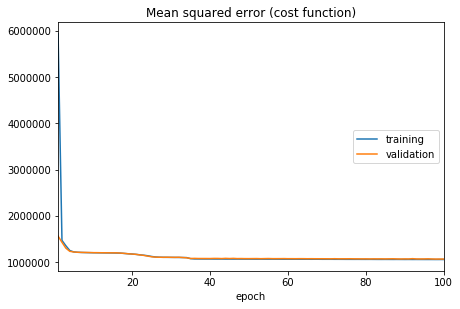

In [200]:
model.fit(X_train_std, y_train, batch_size = 20, epochs = 100,validation_split=0.2, callbacks=[PlotLossesKeras()], verbose=1)

In [201]:
y_pred = model.predict(X_test_std)

In [202]:
r2_score(y_test, y_pred)

0.8916858252953622

In [206]:
y_pred[1:10]

array([[ 5598.5107],
       [ 4389.9336],
       [12234.975 ],
       [ 6292.384 ],
       [15207.395 ],
       [ 4200.547 ],
       [ 4593.0728],
       [ 5186.2017],
       [14055.232 ]], dtype=float32)

In [207]:
rmspe(y_pred.flatten(),y_test)

0.20671134598551266

## Stacking

In [208]:
lr = LinearRegression()
dtc = DecisionTreeRegressor()
rf = RandomForestRegressor()

stregr = StackingRegressor(regressors=[dtc, lr], meta_regressor=rf)

In [209]:
stack = stregr.fit(X_train_std, y_train)

In [210]:
y_pred_stack = stack.predict(X_test_std)

In [211]:
r2_score(y_test,y_pred_stack)

0.8417806154308942

In [212]:
rmspe(y_pred_stack,y_test)

0.23062896703138935

## SVR

In [ ]:
svr = SVR(kernel='linear')
svr.fit(X_train_std, y_train)
y_pred_svr = svr.predict(X_test_std)

In [ ]:
r2_score(y_test,y_pred_svr)

In [ ]:
rmspe(y_pred_svr,y_test)

## Bagging

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor

In [ ]:
# para_bag = {'base_estimator':[DecisionTreeRegressor(), KNeighborsRegressor()],"max_samples": [0.5, 1.0],}
bag = BaggingRegressor()
# grid_bag = GridSearchCV(bag, para_bag, cv = 5, scoring = two_scorer())

In [ ]:
bag.fit(X_train_std, y_train)

In [ ]:
bag.base_estimator_

In [ ]:
y_pred_bag = bag.predict(X_test_std)

In [ ]:
r2_score(y_test,y_pred_bag)

In [ ]:
rmspe(y_pred_bag,y_test)